## Intrusion Detection with ML using the NSL-KDD Dataset

Computer networks and the communications that occur within them, as well as between different networks, needs to be monitored in order to detect any type of external attack or any type of internal malicious activity which would indicate that a breach has occured.  Typically an Intrusion Detection/Prevention System will match traffic against against known patterns related to malicious activity via the use of regular expression pattern matching.  This pattern matching is referred to as signature based detection.  However, this can be prone to error and at times will produce many false positives.


The objective of this project is to see if machine learning can be used as an additional tool to try and detect malicious activity from the data collected related to network telemetry to augment the traditional, signature based detection used by Intrusion Detection/Prevention systems.  Please note, the project will not compare the methods against each other with regard to efficacy, rather it will only measure the efficacy of ML when applied to the same data with the intent of using ML to detect malicious activity that has already been tagged beforehand (supervised learning).  Please note, the use of machine learning to detect malicious activity from network telemetry is typically referred to as "anomaly based detection".

In [1]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.1/318.1 MB 11.8 MB/s eta 0:00:00


In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import gc

from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, \
  confusion_matrix, ConfusionMatrixDisplay, mean_squared_error, classification_report, roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier


warnings.filterwarnings("ignore")

## Exploratory Data Analysis

In [35]:
df = pd.read_csv('data/KDD_Train.csv', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


In [36]:
columns = ([
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes',
    'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in',
    'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations',
    'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login',
    'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate',
    'rerror_rate', 'srv_rerror_rate' ,
    'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
    'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate',
    'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
    'dst_host_srv_rerror_rate', 'class', 'level'
])
df.columns = columns
df.head(10)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class,level
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21
5,0,tcp,private,REJ,0,0,0,0,0,0,...,0.07,0.07,0.00,0.00,0.00,0.00,1.00,1.00,neptune,21
6,0,tcp,private,S0,0,0,0,0,0,0,...,0.04,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,21
7,0,tcp,private,S0,0,0,0,0,0,0,...,0.06,0.07,0.00,0.00,1.00,1.00,0.00,0.00,neptune,21
8,0,tcp,remote_job,S0,0,0,0,0,0,0,...,0.09,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,21
9,0,tcp,private,S0,0,0,0,0,0,0,...,0.05,0.06,0.00,0.00,1.00,1.00,0.00,0.00,neptune,21


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 43 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125973 non-null  int64  
 1   protocol_type                125973 non-null  object 
 2   service                      125973 non-null  object 
 3   flag                         125973 non-null  object 
 4   src_bytes                    125973 non-null  int64  
 5   dst_bytes                    125973 non-null  int64  
 6   land                         125973 non-null  int64  
 7   wrong_fragment               125973 non-null  int64  
 8   urgent                       125973 non-null  int64  
 9   hot                          125973 non-null  int64  
 10  num_failed_logins            125973 non-null  int64  
 11  logged_in                    125973 non-null  int64  
 12  num_compromised              125973 non-null  int64  
 13 

In [38]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
duration,125973.0,287.144650,2.604515e+03,0.0,0.00,0.00,0.00,4.290800e+04
src_bytes,125973.0,45566.743000,5.870331e+06,0.0,0.00,44.00,276.00,1.379964e+09
dst_bytes,125973.0,19779.114421,4.021269e+06,0.0,0.00,0.00,516.00,1.309937e+09
land,125973.0,0.000198,1.408607e-02,0.0,0.00,0.00,0.00,1.000000e+00
wrong_fragment,125973.0,0.022687,2.535300e-01,0.0,0.00,0.00,0.00,3.000000e+00
urgent,125973.0,0.000111,1.436603e-02,0.0,0.00,0.00,0.00,3.000000e+00
hot,125973.0,0.204409,2.149968e+00,0.0,0.00,0.00,0.00,7.700000e+01
num_failed_logins,125973.0,0.001222,4.523914e-02,0.0,0.00,0.00,0.00,5.000000e+00
logged_in,125973.0,0.395736,4.890101e-01,0.0,0.00,0.00,1.00,1.000000e+00
num_compromised,125973.0,0.279250,2.394204e+01,0.0,0.00,0.00,0.00,7.479000e+03


Changing the labels so that they only show two unique values: 'normal' which represents normal activity and 'attack' which represents malicious activity that represents an intrusion.

In [39]:
df.loc[df['class'] == "normal", "class"] = 'normal'
df.loc[df['class'] != 'normal', "class"] = 'attack'

df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class,level
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,attack,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


Let's graph the class distribution and the network protocols.  As you can see below the classes are evenly balanced and transmission control protocol seems to be more prevelent in the data than other networking protocols.

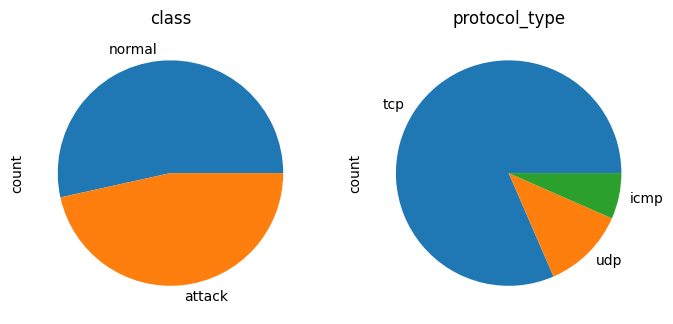

In [40]:
fig, axes = plt.subplots(1, 2)
for ax, col in zip(axes.ravel(), ['class', 'protocol_type', 'flag']):
  df[col].value_counts().plot(ax=ax, kind='pie', figsize=(8, 8), fontsize=10)
  ax.set_title(str(col), fontsize=12)


Now let's see the distribution of the data for the various numerical features.  Features will be standardized before being processed by any model.

['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'level']


Text(0.5, 1.1, 'Box plot of numerical variables')

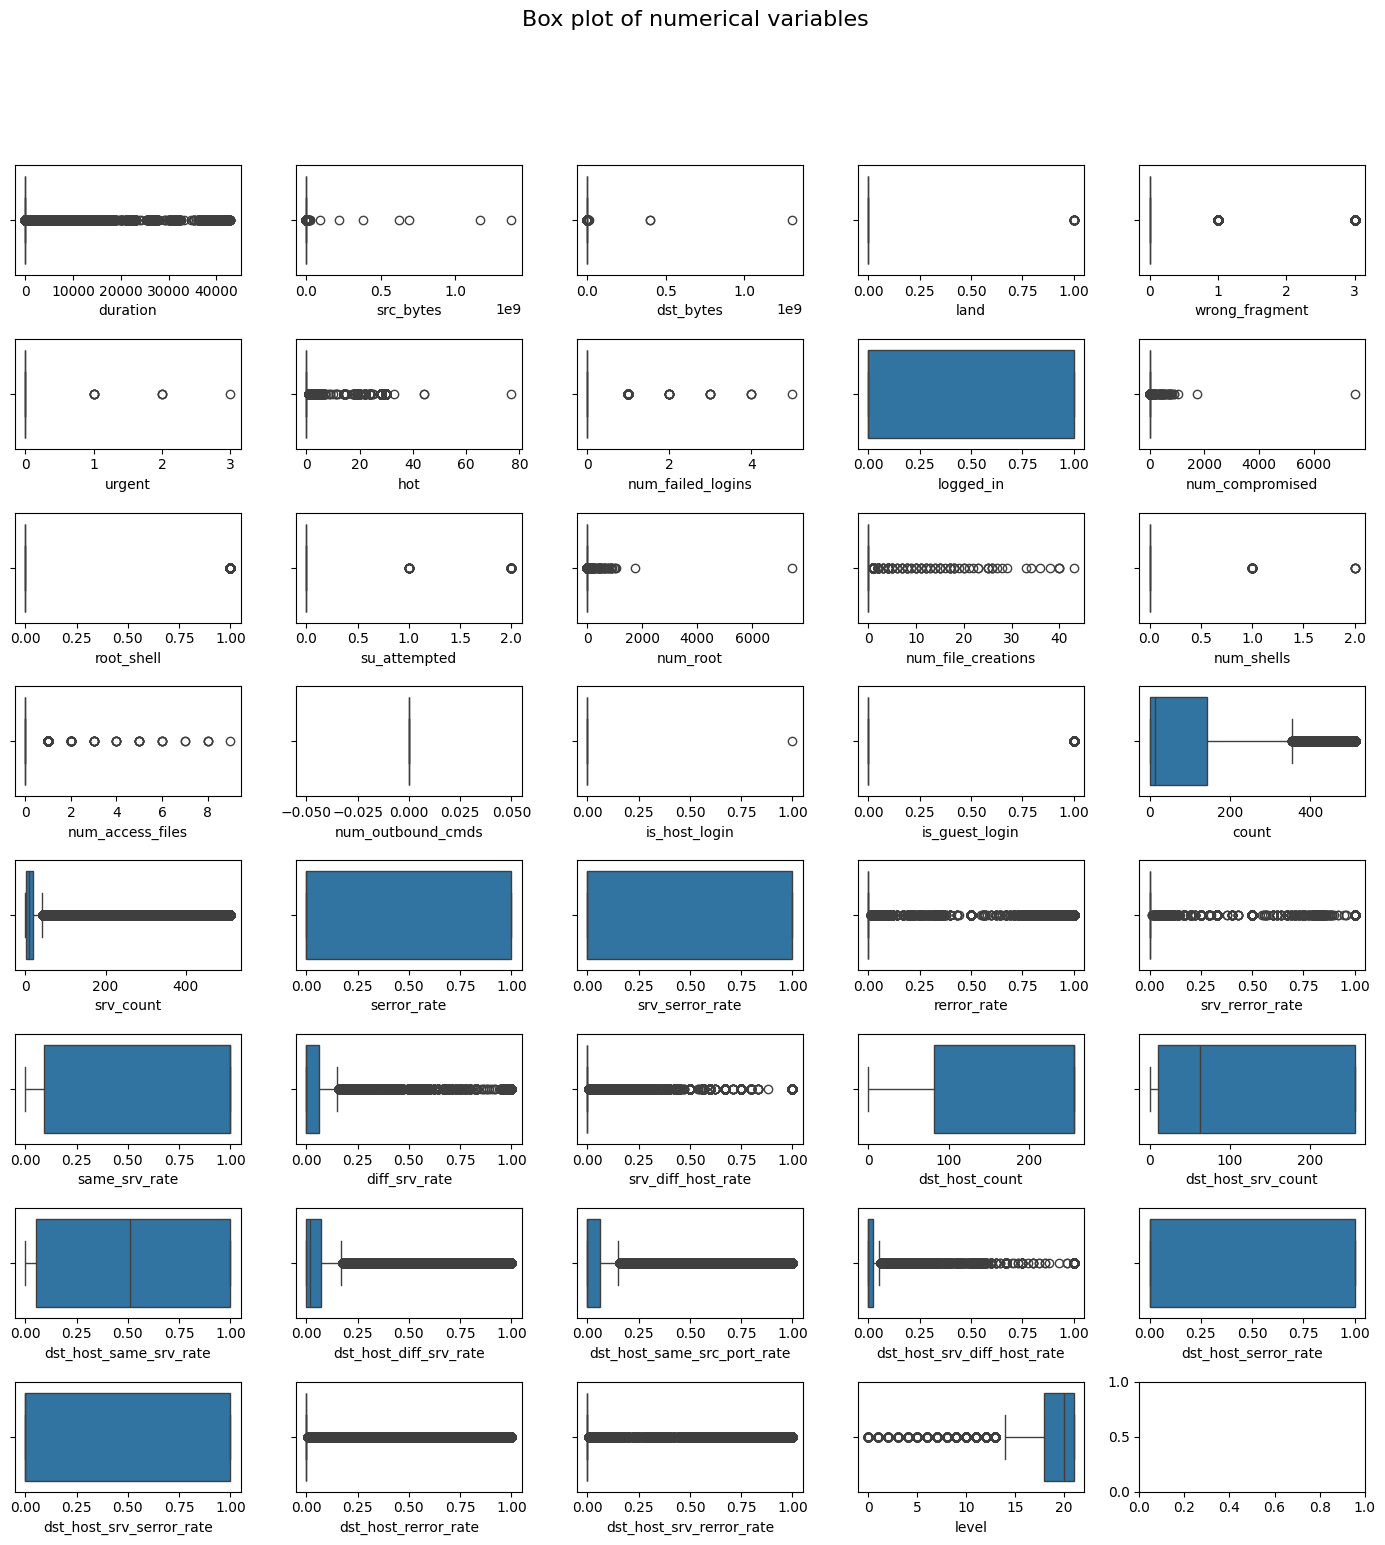

In [41]:
num_column_lst = []
for icol in df.columns:
    if df[icol].dtypes in ['float64', 'int64']:
        num_column_lst.append(icol)
print(num_column_lst)

fig, axs = plt.subplots(nrows = 8, ncols=5, figsize = (14,14))
for name,ax in zip(num_column_lst,axs.flatten()):
  sns.boxplot(data=df,x=name,ax=ax)
  # sns.violinplot(data=df,x=name,ax=ax)
  # plt.show()
fig.tight_layout()
fig.suptitle('Box plot of numerical variables',y=1.1,fontsize=16)

As can be seen above, the following features behave as if they were constant features and should be dropped from the dataset:

logged_in, serror_rate, srv_serror_rate, dest_host_serror_rate and dst_host_srv_serror_rate

In [42]:
#Taking out logged_in, serror_rate, srv_serror_rate, dest_host_serror_rate and dst_host_srv_serror_rate from dataframe
useless_cols=['logged_in','serror_rate','srv_serror_rate','dst_host_serror_rate','dst_host_srv_serror_rate', 'land']
df_1 = df.drop(useless_cols, axis=1)

Need to scale the numerical columns before testing models.  Scaling data before model testing is a crucial preprocessing step in machine learning that can significantly impact model performance, especially for algorithms sensitive to feature magnitudes.

Categorical columns are converted to represent 'True' or 'False' according to unique values and represented via corresponding column with the following nomeclature: feature_name + unique_value.


In [43]:
def Scaling(df_num, cols):
    std_scaler = RobustScaler()
    std_scaler_temp = std_scaler.fit_transform(df_num)
    std_df = pd.DataFrame(std_scaler_temp, columns =cols)
    return std_df

In [44]:
cat_cols = ['is_host_login','protocol_type','service','flag','is_guest_login', 'level', 'class']
def preprocess(dataframe):
    df_num = dataframe.drop(cat_cols, axis=1)
    num_cols = df_num.columns
    scaled_df = Scaling(df_num, num_cols)

    dataframe.drop(labels=num_cols, axis="columns", inplace=True)
    dataframe[num_cols] = scaled_df[num_cols]

    dataframe.loc[dataframe['class'] == "normal", "class"] = 0
    dataframe.loc[dataframe['class'] != 0, "class"] = 1

    dataframe = pd.get_dummies(dataframe, columns = ['protocol_type', 'service', 'flag'])
    return dataframe

Let's investigate the distribution of categorical features.

Text(0.5, 1.05, 'Distribution of Categorical variables')

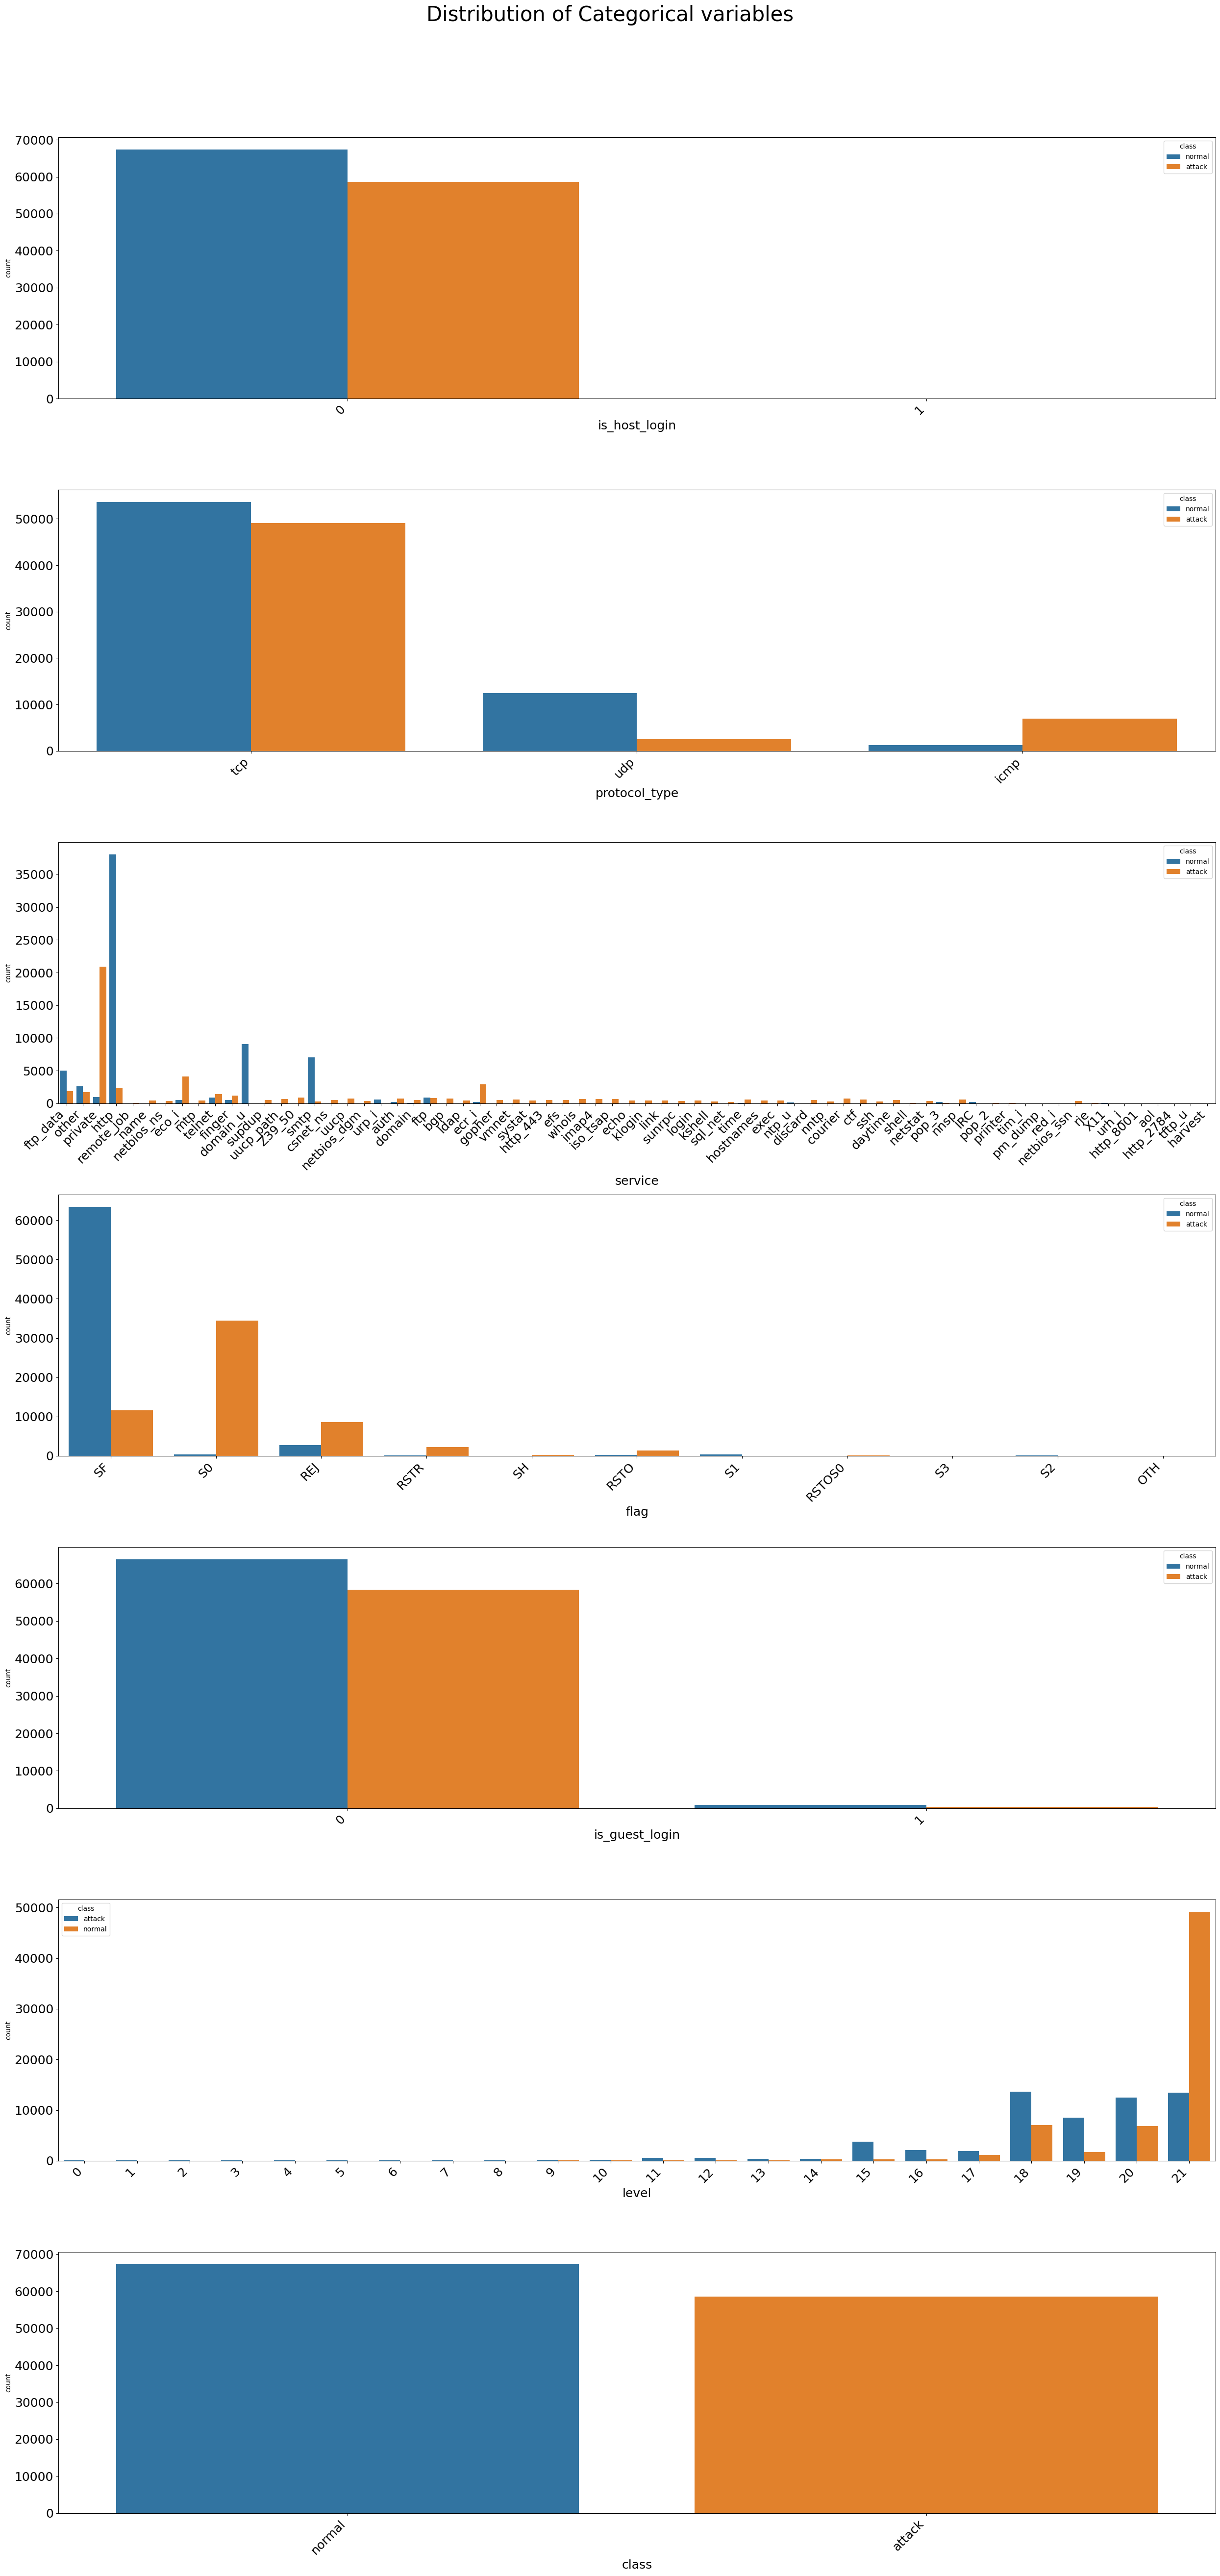

In [45]:
fig, axs = plt.subplots(nrows = 7, ncols=1, figsize = (25,50))
for name,ax in zip(cat_cols,axs.flatten()):
    sns.countplot(data=df_1,x=name,ax=ax,hue='class')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right',fontsize=18)
    ax.set_yticklabels(ax.get_yticklabels(),fontsize=18)
    ax.set_xlabel(ax.get_xlabel(),fontsize=18)

fig.tight_layout()
fig.suptitle('Distribution of Categorical variables',y=1.05,fontsize=30)

In [46]:
scaled_train = preprocess(df_1)
scaled_train

,is_host_login,is_guest_login,class,level,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0,0,0,20,0.0,1.619565,0.000000,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,True,False
1,0,0,0,15,0.0,0.369565,0.000000,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,True,False
2,0,0,1,19,0.0,-0.159420,0.000000,0.0,0.0,0.0,...,False,False,False,False,True,False,False,False,False,False
3,0,0,0,21,0.0,0.681159,15.800388,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,True,False
4,0,0,0,21,0.0,0.561594,0.813953,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,0,0,1,20,0.0,-0.159420,0.000000,0.0,0.0,0.0,...,False,False,False,False,True,False,False,False,False,False
125969,0,0,0,21,8.0,0.221014,0.281008,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,True,False
125970,0,0,0,18,0.0,7.923913,0.744186,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,True,False
125971,0,0,1,20,0.0,-0.159420,0.000000,0.0,0.0,0.0,...,False,False,False,False,True,False,False,False,False,False


## Feature Importnce and Feature Selection via PCA

Principal Component Analysis (PCA) is a data analysis technique used to reduce the dimensionality of a dataset while preserving as much information as possible. It transforms the original variables into a new set of uncorrelated variables, called principal components, that capture the most variance in the data.

PCA takes a dataset with multiple variables as input, and it produces a dataset into a lower subspace, that is, a reduced dataset with fewer variables. It is often used in exploratory data analysis for building predictive models, but it is also used in data preprocessing for dimensionality reduction.

In [47]:
x = scaled_train.drop(['class', 'level'] , axis = 1).values
y = scaled_train['class'].values
y_reg = scaled_train['level'].values

pca = PCA(n_components=4)
pca = pca.fit(x)
x_reduced = pca.transform(x)


y = y.astype('int')
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train_reduced, x_test_reduced, y_train_reduced, y_test_reduced = train_test_split(x_reduced, y, test_size=0.2, random_state=42)
x_train_reg, x_test_reg, y_train_reg, y_test_reg = train_test_split(x, y_reg, test_size=0.2, random_state=42)


In [48]:
feature_names = df.columns.values
component_weights = pca.components_
# Create a mapping between component weights and feature names
feature_weights_mapping = {}
for i, component in enumerate(component_weights):
  component_feature_weights = zip(feature_names, component)
  sorted_feature_weight = sorted(
      component_feature_weights, key=lambda x: abs(x[1]), reverse=True)
  feature_weights_mapping[f"Component {i}"] = sorted_feature_weight

# Accessing feature names contributing to Principal Component
print("Feature names contributing to Principal Components\n")
for feature, weight in feature_weights_mapping.items():
  print(f"{feature}: {weight}\n")



Feature names contributing to Principal Components

Component 0: [('flag', np.float64(0.9999613354103188)), ('service', np.float64(0.008793022510397486)), ('src_bytes', np.float64(0.00010216923700525114)), ('num_access_files', np.float64(-6.050224995114852e-07)), ('diff_srv_rate', np.float64(-4.454651827949876e-07)), ('is_host_login', np.float64(2.1591595539717466e-07)), ('num_outbound_cmds', np.float64(2.1086705676396146e-07)), ('num_shells', np.float64(-1.999528127287756e-07)), ('dst_host_count', np.float64(1.901882507090101e-07)), ('same_srv_rate', np.float64(1.6416021197534288e-07)), ('serror_rate', np.float64(-1.5464072709910265e-07)), ('srv_rerror_rate', np.float64(1.4898583389964705e-07)), ('rerror_rate', np.float64(-1.4878058159008386e-07)), ('srv_serror_rate', np.float64(-1.4824283432407816e-07)), ('is_guest_login', np.float64(9.037266246929592e-08)), ('dst_host_same_srv_rate', np.float64(6.711017369992351e-08)), ('count', np.float64(-6.313187448913989e-08)), ('num_compromised

Below one can see the amount of variance that can be explained by each of the principle component analysis feature sets.

([<matplotlib.axis.XTick at 0x7916b0e97210>,
 [Text(0, 0, '0'), Text(1, 0, '1'), Text(2, 0, '2'), Text(3, 0, '3')])

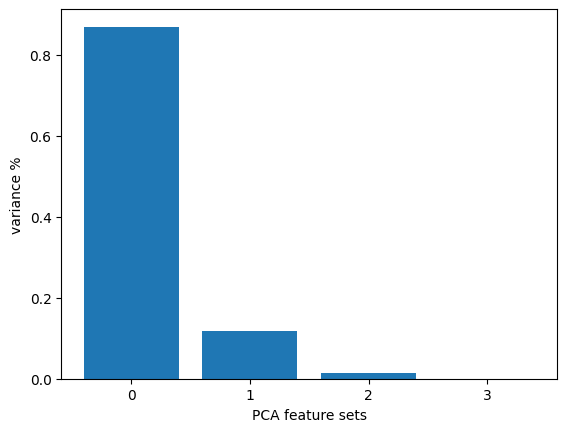

In [49]:
var = pca.explained_variance_ratio_
plt.bar(list(range(var.shape[0])),var)
feature = range(pca.n_components_)
plt.xlabel('PCA feature sets')
plt.ylabel('variance %')
plt.xticks(feature)

Features are listed along with coeficients below in desending order (most important features at the top):

In [50]:
pca0_features = pd.DataFrame(feature_weights_mapping["Component 0"])
pca0_features.columns = ['feature name', 'feature weight']
pca0_features

,feature name,feature weight
0,flag,9.999613e-01
1,service,8.793023e-03
2,src_bytes,1.021692e-04
3,num_access_files,-6.050225e-07
4,diff_srv_rate,-4.454652e-07
5,is_host_login,2.159160e-07
6,num_outbound_cmds,2.108671e-07
7,num_shells,-1.999528e-07
8,dst_host_count,1.901883e-07
9,same_srv_rate,1.641602e-07


We will leave all of the remaining features in the training and testing datasets.  Dropping features that do not contribute much to the variance of the dataset (see above list for features listed towards the bottom of the list) will not help much with regards to improve the efficiency of model training with regards to this particular dataset and models being trained and tested. Furthermore, we will be using cross validation and hyperparamter tuning to further avoid over fitting and manage feature selection.

Below we will build metrics to evaluate our models.

In [51]:
results_df = pd.DataFrame({'logistic_regression': []},
                          columns=['ROC_AUC','Accuracy', 'F1', 'Precision', 'Recall'])

We will begin by testing our baseline model which is Logistic Regression without cross validation.

In [52]:
simple_lgr = LogisticRegression()
simple_lgr.fit(x_train, y_train)
y_hat = simple_lgr.predict(x_test)
y_hat_probs = simple_lgr.predict_proba(x_test)
simple_lgr_scores = classification_report(y_test, y_hat)
baseline_roc_score = roc_auc_score(y_test, y_hat_probs[:, 1])

results_df.loc['Baseline_Model', 'Accuracy'] = accuracy_score(y_test, y_hat)
results_df.loc['Baseline_Model', 'ROC_AUC'] = baseline_roc_score
results_df.loc['Baseline_Model', 'F1'] = f1_score(y_test, y_hat)
results_df.loc['Baseline_Model', 'Precision'] = precision_score(y_test, y_hat)
results_df.loc['Baseline_Model', 'Recall'] = recall_score(y_test, y_hat)
results_df

,ROC_AUC,Accuracy,F1,Precision,Recall
Baseline_Model,0.886264,0.88327,0.874053,0.881413,0.866814


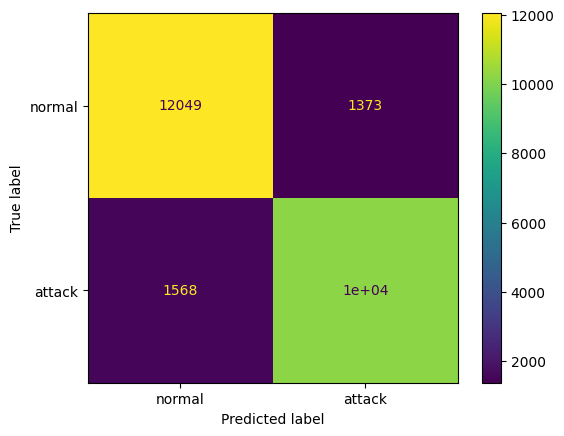

In [53]:
ConfusionMatrixDisplay.from_predictions(y_test, y_hat, display_labels = ['normal', 'attack'])

As you can see above from the confusion matrix and reported metrics, this baseline model is fairly accurate producing a result of over 88% (1,568 false positives and 1,373 false negatives).

Now we will test logistic regression with cross validation used to find optimal model hyperparameters.

In [54]:
lgr_params = {'penalty': ['l1', 'l2', 'elasticnet']}

lgr_model = LogisticRegression(class_weight='balanced')
lgr_grid_mod = GridSearchCV(lgr_model, param_grid=lgr_params, scoring='roc_auc')
lgr_grid_mod.fit(x_train, y_train)
y_hat = lgr_grid_mod.predict(x_test)
y_hat_probs = lgr_grid_mod.predict_proba(x_test)
simple_lgr_grid_scores = classification_report(y_test, y_hat)
baseline_roc_score = roc_auc_score(y_test, y_hat_probs[:, 1])

results_df.loc['logistic_regression', 'Accuracy'] = accuracy_score(y_test, y_hat)
results_df.loc['logistic_regression', 'ROC_AUC'] = baseline_roc_score
results_df.loc['logistic_regression', 'F1'] = f1_score(y_test, y_hat)
results_df.loc['logistic_regression', 'Precision'] = precision_score(y_test, y_hat)
results_df.loc['logistic_regression', 'Recall'] = recall_score(y_test, y_hat)
results_df

,ROC_AUC,Accuracy,F1,Precision,Recall
Baseline_Model,0.886264,0.88327,0.874053,0.881413,0.866814
logistic_regression,0.900135,0.882239,0.875047,0.867775,0.882443


The optimal model hyperparamters for Logistic Regression:

In [55]:
print(f'Best parameters for Logistic Regression found during grid search={lgr_grid_mod.best_params_}')

Best parameters for Logistic Regression found during grid search={'penalty': 'l2'}


As you can see above, L2 regularization (Ridge regression) was used to reduce model complexity.

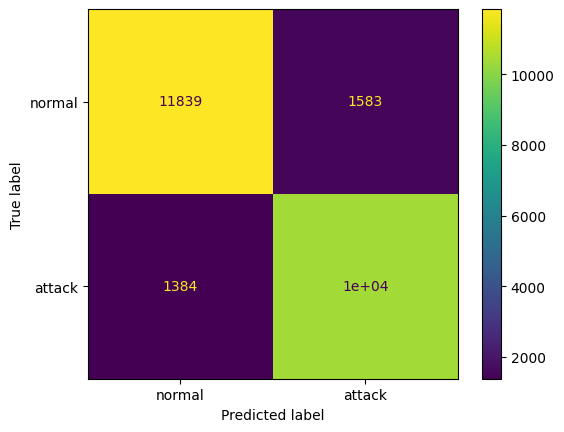

In [56]:
ConfusionMatrixDisplay.from_predictions(y_test, y_hat, display_labels = ['normal', 'attack'])

As you can see above from the confusion matrix and reported metrics, this model is fairly accurate producing a result of over 88% (1,583 false positives and 1,384 false negatives).  This is very similar to the baseline model results.

Now we will test XGBOOST model with cross validation used to find optimal model hyperparameters.

In [57]:
xgb_params = {
    "n_estimators": [50,64,100,128],
    "max_depth": [2, 3, 4,5,6],
    "learning_rate": [0.01,0,0.03, 0.05, 0.1],
    "subsample": [0.5, 0.8],
    "colsample_bytree": [0.5, 0.8]
}

xgb_model = XGBClassifier(random_state=42)
xgb_grid_mod = GridSearchCV(xgb_model, param_grid=xgb_params, scoring='roc_auc')
xgb_grid_mod.fit(x_train, y_train)
y_hat = xgb_grid_mod.predict(x_test)
y_hat_probs = xgb_grid_mod.predict_proba(x_test)
simple_xgb_grid_scores = classification_report(y_test, y_hat)
baseline_roc_score = roc_auc_score(y_test, y_hat_probs[:, 1])

results_df.loc['xgboost', 'Accuracy'] = accuracy_score(y_test, y_hat)
results_df.loc['xgboost', 'ROC_AUC'] = baseline_roc_score
results_df.loc['xgboost', 'F1'] = f1_score(y_test, y_hat)
results_df.loc['xgboost', 'Precision'] = precision_score(y_test, y_hat)
results_df.loc['xgboost', 'Recall'] = recall_score(y_test, y_hat)
results_df

,ROC_AUC,Accuracy,F1,Precision,Recall
Baseline_Model,0.886264,0.88327,0.874053,0.881413,0.866814
logistic_regression,0.900135,0.882239,0.875047,0.867775,0.882443
xgboost,0.999991,0.998571,0.998471,0.99881,0.998131


In [58]:
print(f'Best parameters for Logistic Regression found during grid search={xgb_grid_mod.best_params_}')

Best parameters for Logistic Regression found during grid search={'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 128, 'subsample': 0.8}


Xgboost hyperparameter tuning results listed above.

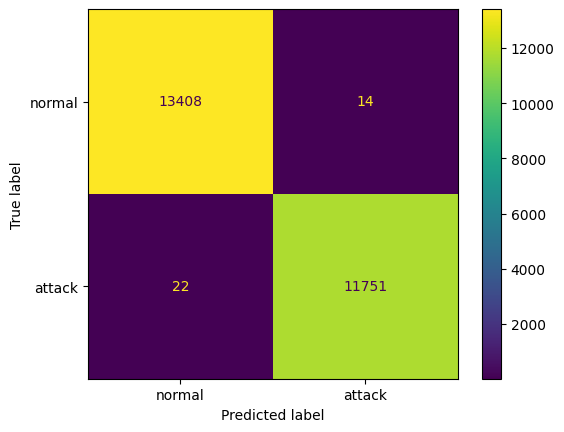

In [59]:
ConfusionMatrixDisplay.from_predictions(y_test, y_hat, display_labels = ['normal', 'attack'])

As you can see above from the confusion matrix and reported metrics, this classification model is extremely accurate producing a result of over 99% (14 false positives and 22 false negatives).  This is much better than the logistic regression model with and without cross validation.

Now we will test RandomForest Classifier model with cross validation used to find optimal model hyperparameters.

In [60]:
rfc_params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

rfc_model = RandomForestClassifier()
rfc_grid_mod = GridSearchCV(rfc_model, param_grid=rfc_params, scoring='roc_auc')
rfc_grid_mod.fit(x_train, y_train)
y_hat = rfc_grid_mod.predict(x_test)
y_hat_probs = rfc_grid_mod.predict_proba(x_test)
simple_rfc_grid_scores = classification_report(y_test, y_hat)
baseline_roc_score = roc_auc_score(y_test, y_hat_probs[:, 1])

results_df.loc['randomforestclass', 'Accuracy'] = accuracy_score(y_test, y_hat)
results_df.loc['randomforestclass', 'ROC_AUC'] = baseline_roc_score
results_df.loc['randomforestclass', 'F1'] = f1_score(y_test, y_hat)
results_df.loc['randomforestclass', 'Precision'] = precision_score(y_test, y_hat)
results_df.loc['randomforestclass', 'Recall'] = recall_score(y_test, y_hat)
results_df

,ROC_AUC,Accuracy,F1,Precision,Recall
Baseline_Model,0.886264,0.88327,0.874053,0.881413,0.866814
logistic_regression,0.900135,0.882239,0.875047,0.867775,0.882443
xgboost,0.999991,0.998571,0.998471,0.99881,0.998131
randomforestclass,0.99999,0.99869,0.998598,0.999235,0.997961


In [61]:
print(f'Best parameters for Logistic Regression found during grid search={rfc_grid_mod.best_params_}')

Best parameters for Logistic Regression found during grid search={'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}


RandomForestClassifier hyperparameter tuning results listed above.

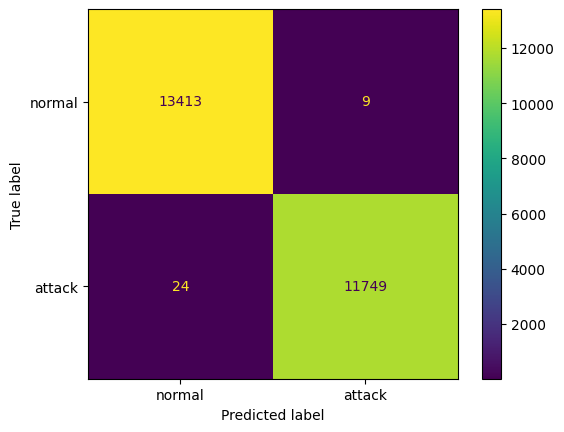

In [62]:
ConfusionMatrixDisplay.from_predictions(y_test, y_hat, display_labels = ['normal', 'attack'])

As you can see above from the confusion matrix and reported metrics, this classification model is extremely accurate producing a result of over 99% (9 false positives and 24 false negatives).  This is much better than the logistic regression model with and without cross validation.

When comparing the above results to the XGBOOST model results the two seem to be very similar, however, the RandomForestClassifier model produced 2 more false negatives then the XGBOOST model.  In other words, the XGBOOST model was a little less precise then the RandomForestClassifier model but it had a better recall score.  With regards to anomaly detection, recall is a more important metric as it can be used to minimize false negatives which are more dangerous than false positives.  Based on the above metrics and confusion matricies, the XGBOOST model seems to slightly outperform the RandomForestClassifier model.  In conclusion, both models seem to be very accurate and precise.

In conclusion, machine learning seems to accurately predict anomalous activity when used in a supervised learning example such as the one used in this report.  As for the type of classification machine learning models XGBOOST and RandomForestClassifier seem to produce fairly accurate results.  XGBOOST seems to be slighlty better at reducing false negatives which ideally need to be minimized to address this prticular use case for machine learning.